In [1]:
import scanpy as sc

from gene_trajectory.add_gene_bin_score import add_gene_bin_score
from gene_trajectory.coarse_grain import select_top_genes, coarse_grain_adata
from gene_trajectory.extract_gene_trajectory import get_gene_embedding, extract_gene_trajectory
from gene_trajectory.get_graph_distance import get_graph_distance
from gene_trajectory.gene_distance_shared import cal_ot_mat
from gene_trajectory.run_dm import run_dm
from gene_trajectory.plot.gene_trajectory_plots import plot_gene_trajectory_3d, plot_gene_trajectory_umap
from gene_trajectory.util.download_file import download_file_if_missing

2025-04-28 12:36:33.049168: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745858193.217824  128256 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745858193.224391  128256 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
adata = sc.read_h5ad('/data/peer/chene5/_hd_stats/tutorial_data/human_myeloid_scanpy_obj.h5ad')

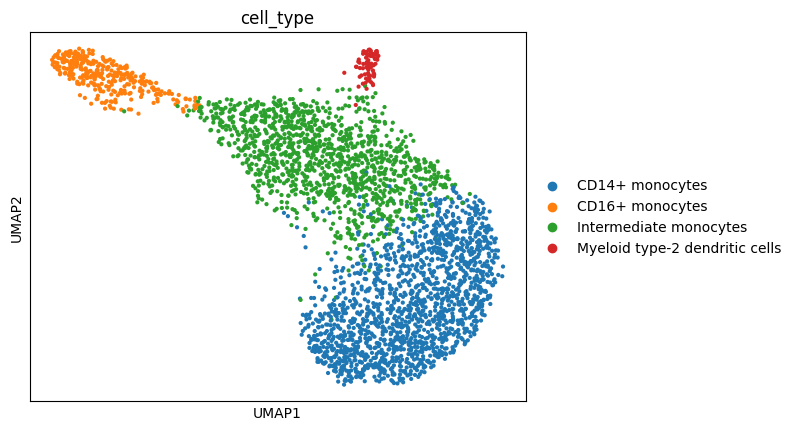

In [4]:
adata.obs['cell_type'] = adata.obs['cluster'].replace({
  0: "CD14+ monocytes",
  1: "Intermediate monocytes",
  2: "CD16+ monocytes",
  3: "Myeloid type-2 dendritic cells"}
)
sc.pl.umap(adata, color=["cell_type"])

### Vanilla gene trajectories

In [ ]:
if 'counts' not in adata.layers:
    adata.layers['counts'] = adata.raw.X.copy()
genes = select_top_genes(adata, layer='counts', n_variable_genes=500) ### these are the top genes that are selected and used

In [ ]:
# construct cell-cell KNN and get cell-cell graph distances

# Adata.X ncells x ngenes -> adata.obsm['X_dm'] (ncells x 30)
run_dm(adata) # generates adata.obsm['X_dm'] - diffusion map embedding of cells
cell_graph_dist = get_graph_distance(adata, k=10)

# Aggregate cells into 500 meta cells using k-means clustering
gene_expression_updated, graph_dist_updated = coarse_grain_adata(adata, graph_dist=cell_graph_dist, features=genes, n=500)


# Calculate gene-gene OT distance on cell graph
gene_dist_mat = cal_ot_mat(gene_expr=gene_expression_updated, 
                           ot_cost=graph_dist_updated, 
                           show_progress_bar=True)

100%|██████████| 31375/31375 [00:01<00:00, 27198.12it/s] 


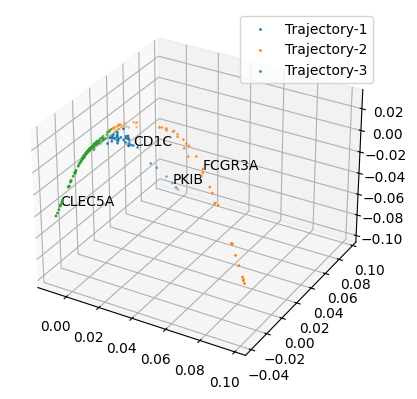

In [12]:
# use diffusion map to get gene embedding
gene_embedding, _ = get_gene_embedding(gene_dist_mat, k = 5)
gene_trajectory = extract_gene_trajectory(gene_embedding, gene_dist_mat, t_list = [4, 8, 7], gene_names=genes, k=5)

plot_gene_trajectory_3d(gene_trajectory, label_genes=['CLEC5A', 'CD1C', 'FCGR3A', 'PKIB'])

### Cell trajectories for metacells (hard to evaluate because no celltype labels)

In [ ]:
# NEW
genes_adata = sc.AnnData(gene_embedding)
genes_adata.obsm['X_dm'] = gene_embedding

In [ ]:
# try to get gene graph by co-opting their functions
gene_graph_dist = get_graph_distance(genes_adata, k=20)
    # had to increase k because disconnected components

In [15]:
gene_expression_updated_T = gene_expression_updated.T

In [ ]:
# Compute cell OT distance on gene graph
new_cell_dist_mat = cal_ot_mat(gene_expr=gene_expression_updated_T, 
                           ot_cost=gene_graph_dist, 
                           show_progress_bar=True)

100%|██████████| 124750/124750 [00:01<00:00, 122322.19it/s]


In [18]:
old_cell_dist_mat = graph_dist_updated

In [37]:
new_cell_dist_mat = new_cell_dist_mat/new_cell_dist_mat.max()
old_cell_dist_mat = old_cell_dist_mat/old_cell_dist_mat.max()

<Axes: >

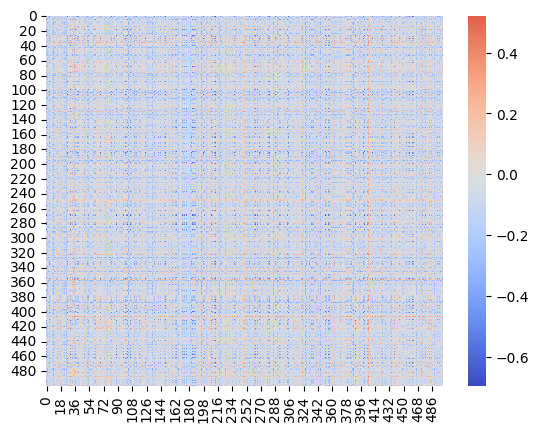

In [ ]:
sns.heatmap(new_cell_dist_mat-old_cell_dist_mat, center=0, cmap='coolwarm')

In [ ]:
# use diffusion map to get gene embedding
old_cell_emb, _ = get_gene_embedding(old_cell_dist_mat, k = 5)
new_cell_emb, _ = get_gene_embedding(new_cell_dist_mat, k = 5)

old_ad = sc.AnnData(old_cell_emb)
new_ad = sc.AnnData(new_cell_emb)

# do umap
sc.pp.neighbors(old_ad, n_neighbors=10)
sc.tl.umap(old_ad)

sc.pp.neighbors(new_ad, n_neighbors=10)
sc.tl.umap(new_ad)

# check where cells get mapped to
sc.tl.leiden(old_ad, resolution=0.4)
new_ad.obs['leiden'] = old_ad.obs['leiden'] 

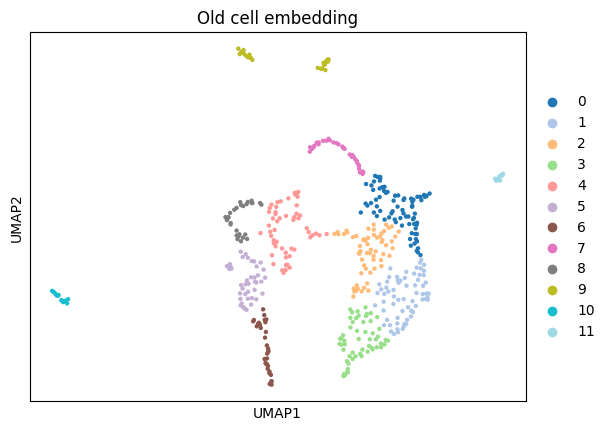

In [22]:
sc.pl.umap(old_ad, title='Old cell embedding', color='leiden', s=40, palette='tab20')

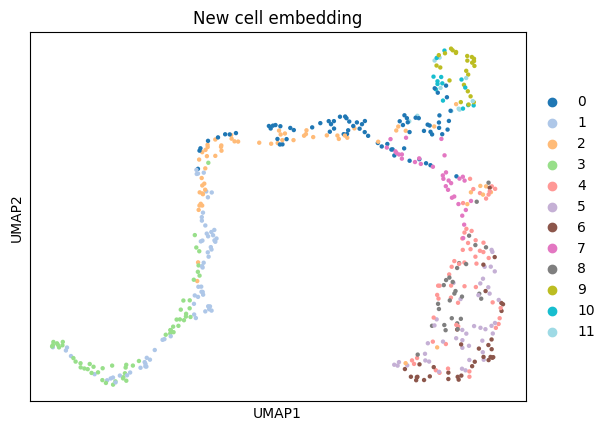

In [23]:
sc.pl.umap(new_ad, title='New cell embedding', color='leiden', s=40, palette='tab20')

### Cell trajectories for first 500 cells (has celltype labels)

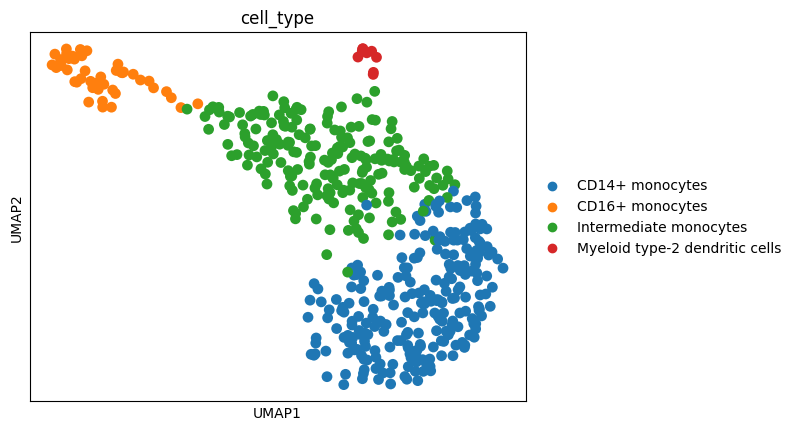

In [24]:
sc.pl.umap(adata[:500], color=["cell_type"])

In [ ]:
# Focus on first 500 cells
adata_top_genes = adata[:500, genes]
X = adata_top_genes.layers["counts"]
all_cells_gene_expression_T = X.T.todense()


In [ ]:
# Updated cell-cell OT dist
dist = cal_ot_mat(gene_expr=all_cells_gene_expression_T, 
                           ot_cost=gene_graph_dist, 
                           show_progress_bar=True)

100%|██████████| 124750/124750 [00:00<00:00, 272494.99it/s]


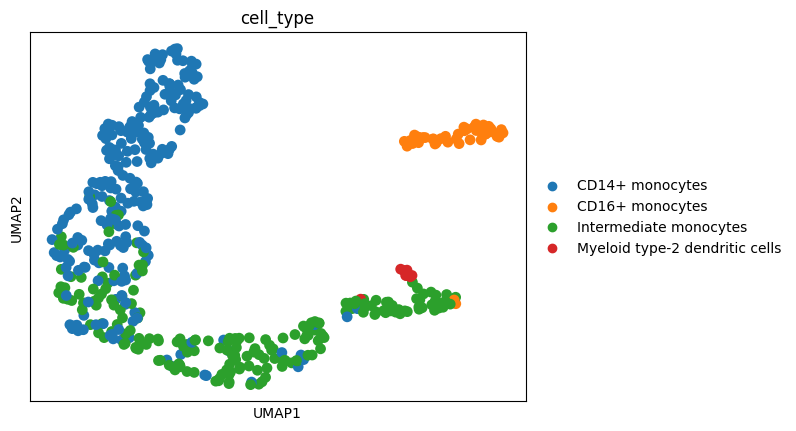

In [ ]:
# use diffusion map to get cell embedding
cell_emb, _ = get_gene_embedding(dist, k = 5)


# do umap -> does not give good results
ad = sc.AnnData(cell_emb)
ad.obs['cell_type'] = adata.obs['cell_type'].values[:500]
sc.pp.neighbors(ad, n_neighbors=10)
sc.tl.umap(ad)
sc.pl.umap(ad, color=["cell_type"])


In [57]:
import pandas as pd
def plot_gene_trajectory_3d_edited(
        gene_trajectory,
        label_genes,
        color_by,
        s: int = 1,
        **kwargs
) -> None:
    """
    Generate a 3D plot of a gene-trajectory object

    :param gene_trajectory: a gene trajectory result
    :param s: scatterplot point size (default: 1)
    :param label_genes: Gene labels to plot (default: None)
    :param color_by: Column to color points by (default: "selected")
    :param kwargs: plot arguments that will be passed to Axes.scatter
    """
    for c in ['DM_1', 'DM_2', 'DM_3', color_by]:
        if c not in gene_trajectory.columns:
            raise ValueError(f'Column {c} is not present in gene trajectory DataFrame')

    ax = plt.axes(projection='3d')
    groups = pd.Categorical(gene_trajectory[color_by])

    for g in groups.categories:
        idxs = groups == g
        ax.scatter(xs=gene_trajectory['DM_1'][idxs],
                   ys=gene_trajectory['DM_2'][idxs],
                   zs=gene_trajectory['DM_3'][idxs],
                   s=s,
                   label=g,
                   **kwargs)

    if label_genes:
        for g in label_genes:
            ax.text(x=gene_trajectory['DM_1'][g],
                    y=gene_trajectory['DM_2'][g],
                    z=gene_trajectory['DM_3'][g],
                    s=g)

    ax.legend()

In [58]:
# use diffusion map to get gene embedding
cell_trajectory = extract_gene_trajectory(cell_emb, dist, t_list = [2, 8, 7], gene_names=adata.obs['cell_type'][:500], k=5)
cell_trajectory['cell_type'] = cell_trajectory.index.values

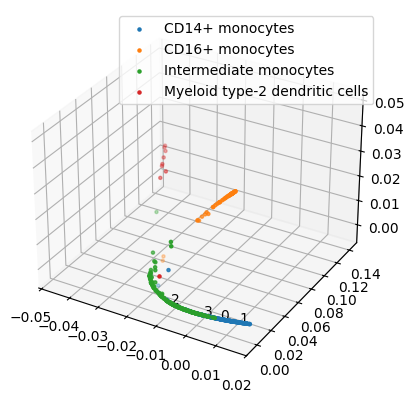

In [104]:
import matplotlib.pyplot as plt
plot_gene_trajectory_3d_edited(cell_trajectory, label_genes=[0,1,2,3], color_by='cell_type', s=5)

# figure out how to make the colros show obs['cell_type']

In [80]:
dist_old = cell_graph_dist[:500, :500]
cell_emb_old, _ = get_gene_embedding(dist_old, k = 5)
cell_trajectory_old = extract_gene_trajectory(cell_emb_old, dist_old, t_list = [2, 8, 7], gene_names=adata.obs['cell_type'][:500], k=5)
cell_trajectory_old['cell_type'] = cell_trajectory_old.index.values


In [85]:
temp = cell_trajectory_old['DM_1']
cell_trajectory_old['DM_1'] = cell_trajectory_old['DM_2']
cell_trajectory_old['DM_2'] = temp

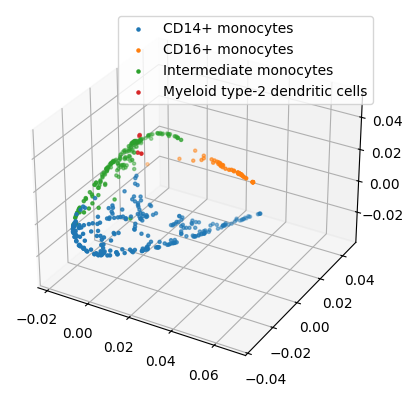

In [92]:
plot_gene_trajectory_3d_edited(cell_trajectory_old, label_genes=[], color_by='cell_type', s=5)


In [60]:
subset = adata[:500].copy()
subset.obs['DM1'] = cell_trajectory['DM_1'].values
subset.obs['DM2'] = cell_trajectory['DM_2'].values
subset.obs['DM3'] = cell_trajectory['DM_3'].values
subset.obs['Pseudoorder-1'] = cell_trajectory['Pseudoorder-1'].values
subset.obs['Pseudoorder-2'] = cell_trajectory['Pseudoorder-2'].values


In [140]:
subset.obs['DM1_old'] = cell_trajectory_old['DM_1'].values
subset.obs['DM2_old'] = cell_trajectory_old['DM_2'].values
subset.obs['DM3_old'] = cell_trajectory_old['DM_3'].values
subset.obs['Pseudoorder-1_old'] = cell_trajectory_old['Pseudoorder-1'].values
subset.obs['Pseudoorder-2_old'] = cell_trajectory_old['Pseudoorder-2'].values
subset.obs['Pseudoorder-3_old'] = cell_trajectory_old['Pseudoorder-3'].values



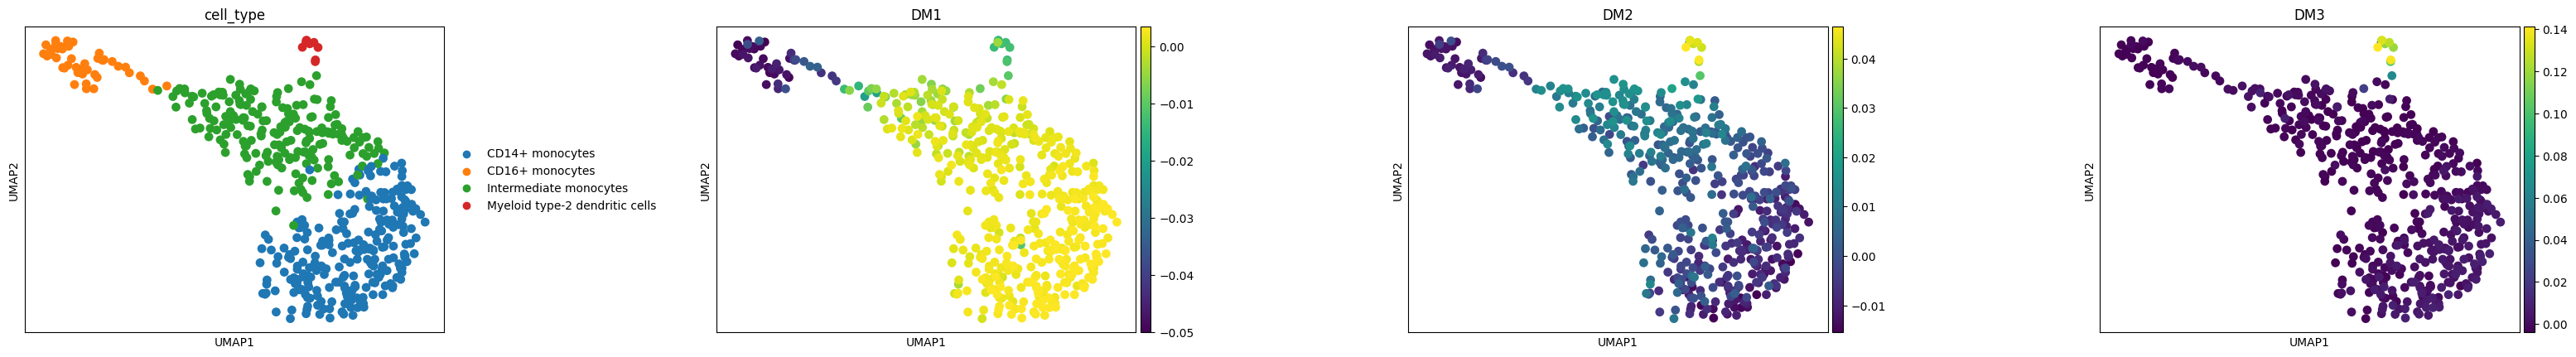

In [61]:
sc.pl.umap(subset, color=["cell_type", 'DM1', 'DM2', 'DM3'], wspace = .5)


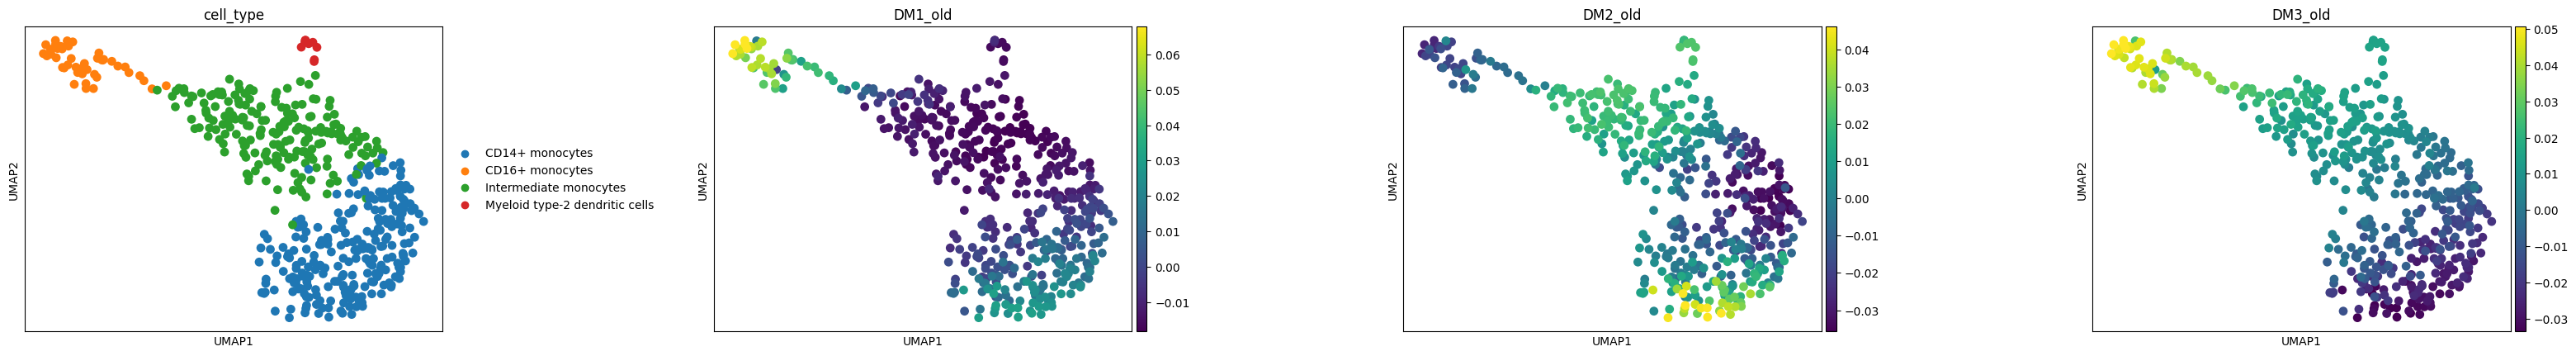

In [138]:
sc.pl.umap(subset, color=["cell_type", 'DM1_old', 'DM2_old', 'DM3_old'], wspace = .5)


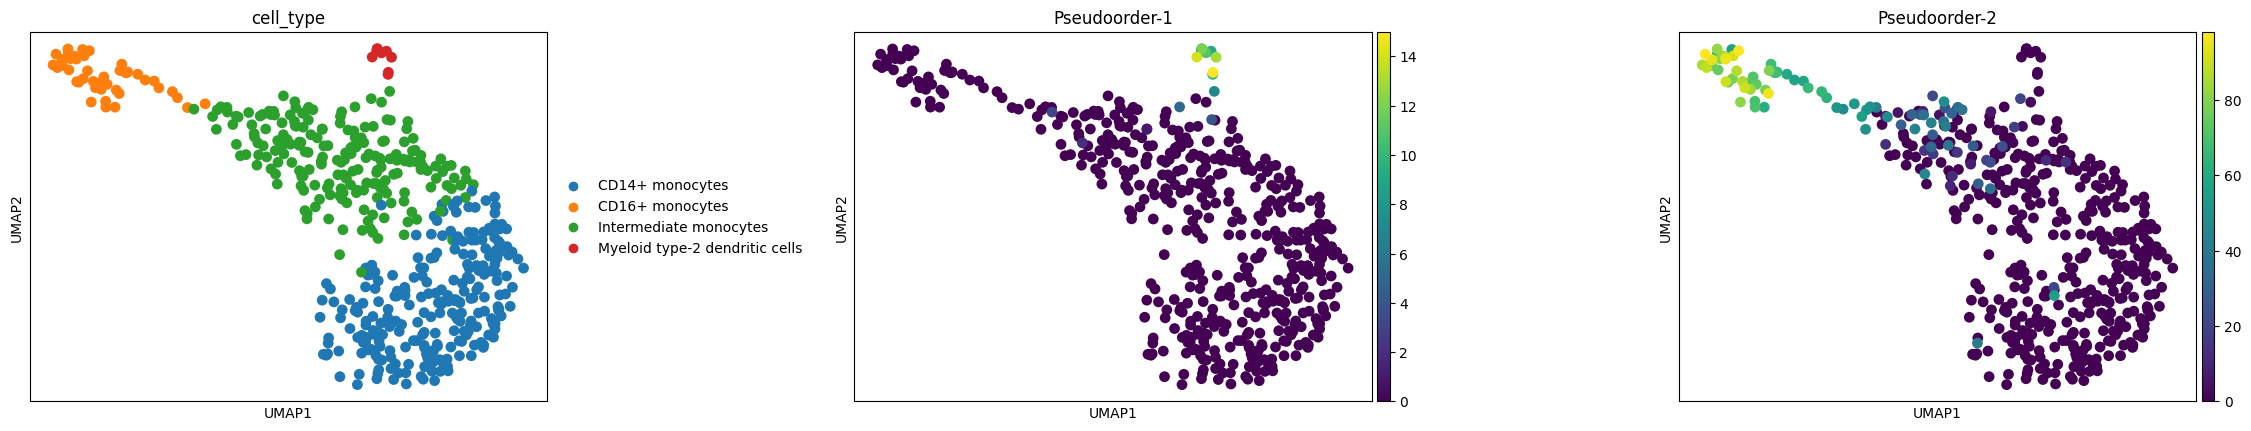

In [62]:
sc.pl.umap(subset, color=["cell_type", 'Pseudoorder-1', 'Pseudoorder-2'], wspace = .45)


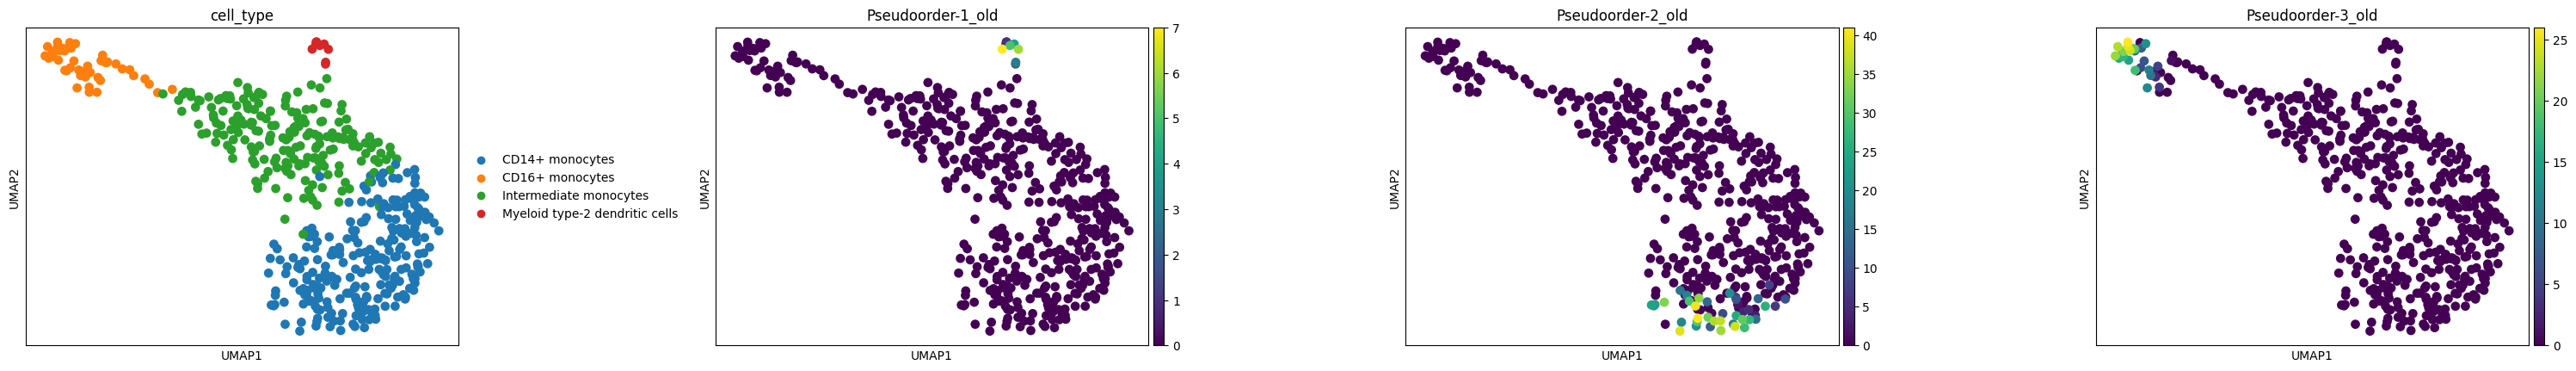

In [142]:
sc.pl.umap(subset, color=["cell_type", 'Pseudoorder-1_old', 'Pseudoorder-2_old', 'Pseudoorder-3_old'], wspace = .45)


### Comparing old and new cell trajectories: checking distance from single cells

In [53]:
old_cell_dist = cell_graph_dist[:500, :500] / cell_graph_dist[:500, :500].max()
new_cell_dist = dist / dist.max()

<Axes: >

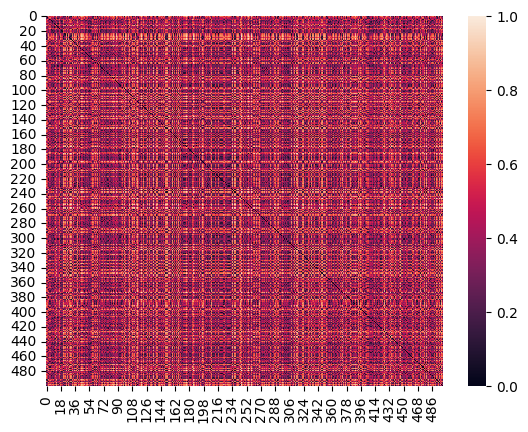

In [54]:
sns.heatmap(old_cell_dist)

<Axes: >

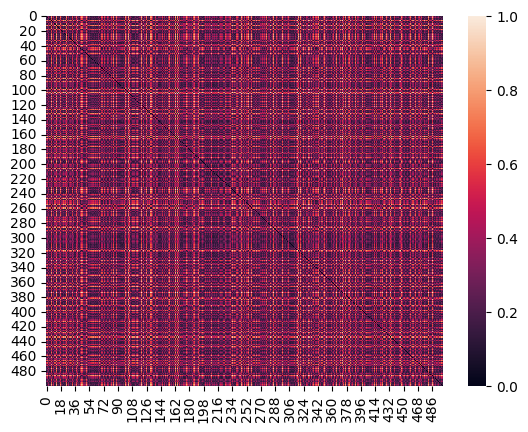

In [ ]:
sns.heatmap(new_cell_dist)

In [133]:
subset.obs['old_0'] = old_cell_dist[:, 0]
subset.obs['new_0'] = new_cell_dist[:, 0]
subset.obs['old_1'] = old_cell_dist[:, 1]
subset.obs['new_1'] = new_cell_dist[:, 1]
subset.obs['old_2'] = old_cell_dist[:, 2]
subset.obs['new_2'] = new_cell_dist[:, 2]
subset.obs['old_3'] = old_cell_dist[:, 3]
subset.obs['new_3'] = new_cell_dist[:, 3]
subset.obs['old_4'] = old_cell_dist[:, 4]
subset.obs['new_4'] = new_cell_dist[:, 4]
subset.obs['old_6'] = old_cell_dist[:, 6]
subset.obs['new_6'] = new_cell_dist[:, 6]
subset.obs['old_88'] = old_cell_dist[:, 88]
subset.obs['new_88'] = new_cell_dist[:, 88]
subset.obs['old_90'] = old_cell_dist[:, 90]
subset.obs['new_90'] = new_cell_dist[:, 90]



subset.obs['cell_0'] = np.concatenate([np.ones(1), np.zeros(len(subset)-1)])
subset.obs['cell_1'] = np.concatenate([np.zeros(1), np.ones(1), np.zeros(len(subset)-2)])
subset.obs['cell_2'] = np.concatenate([np.zeros(2), np.ones(1), np.zeros(len(subset)-3)])
subset.obs['cell_3'] = np.concatenate([np.zeros(3), np.ones(1), np.zeros(len(subset)-4)])
subset.obs['cell_4'] = np.concatenate([np.zeros(4), np.ones(1), np.zeros(len(subset)-5)])
subset.obs['cell_6'] = np.concatenate([np.zeros(6), np.ones(1), np.zeros(len(subset)-7)])
subset.obs['cell_7'] = np.concatenate([np.zeros(7), np.ones(1), np.zeros(len(subset)-8)])
subset.obs['cell_8'] = np.concatenate([np.zeros(8), np.ones(1), np.zeros(len(subset)-9)])
subset.obs['cell_9'] = np.concatenate([np.zeros(9), np.ones(1), np.zeros(len(subset)-10)])
subset.obs['cell_10'] = np.concatenate([np.zeros(10), np.ones(1), np.zeros(len(subset)-11)])
subset.obs['cell_88'] = np.concatenate([np.zeros(88), np.ones(1), np.zeros(len(subset)-89)])
subset.obs['cell_90'] = np.concatenate([np.zeros(90), np.ones(1), np.zeros(len(subset)-91)])



In [131]:
subset[subset.obs['cell_type']=='Myeloid type-2 dendritic cells'].obs

orig.ident  nCount_RNA  nFeature_RNA  observed  \
rna_AAGAACAGTGAGTGAC-1           0     16445.0          3790  0.033625   
rna_AAGAACATCCGCACTT-1           0     15428.0          3694  0.039022   
rna_ACAAGCTCAATCACGT-1           0     19486.0          3706  0.037373   
rna_ACACAGTCAATTGAGA-1           0     19043.0          3911  0.042619   
rna_ACCACAAAGGCGCTCT-1           0     18419.0          3782  0.058055   
rna_ACCCAAATCCAGTGTA-1           0     18532.0          3903  0.032933   
rna_ACTTTCAGTGGAGAAA-1           0     11039.0          2927  0.040767   
rna_AGAGAATTCAAGTAAG-1           0     18525.0          3924  0.040767   
rna_AGGACGAGTCGTATTG-1           0     18575.0          4036  0.034335   

                        simulated  percent.mito  RNA_snn_res.0.4  celltype  \
rna_AAGAACAGTGAGTGAC-1   0.023396      0.092429               10        11   
rna_AAGAACATCCGCACTT-1   0.664430      0.061058               10        11   
rna_ACAAGCTCAATCACGT-1   0.101796      0.088269               10        11   
rna_ACACAGTCAATTGAGA-1   0.494949      0.064958               10        11   
rna_ACCACAAAGGCGCTCT-1   0.275362      0.107389               10        11   
rna_ACCCAAATCCAGTGTA-1   0.209932      0.084287               10        11   
rna_ACTTTCAGTGGAGAAA-1   0.197861      0.090769               10        11   
rna_AGAGAATTCAAGTAAG-1   0.392713      0.075682               10        11   
rna_AGGACGAGTCGTATTG-1   0.139280      0.074886               10        11   

                        RNA_snn_res.0.3  seurat_clusters  ...  cell_6  \
rna_AAGAACAGTGAGTGAC-1                3                3  ...     0.0   
rna_AAGAACATCCGCACTT-1                3                3  ...     0.0   
rna_ACAAGCTCAATCACGT-1                3                3  ...     0.0   
rna_ACACAGTCAATTGAGA-1                3                3  ...     0.0   
rna_ACCACAAAGGCGCTCT-1                3                3  ...     0.0   
rna_ACCCAAATCCAGTGTA-1                3                3  ...     0.0   
rna_ACTTTCAGTGGAGAAA-1                3                3  ...     0.0   
rna_AGAGAATTCAAGTAAG-1                3                3  ...     0.0   
rna_AGGACGAGTCGTATTG-1                3                3  ...     0.0   

                           old_7     new_7  cell_7  cell_8  cell_9  cell_10  \
rna_AAGAACAGTGAGTGAC-1  0.515152  0.562062     0.0     0.0     0.0      0.0   
rna_AAGAACATCCGCACTT-1  0.484848  0.580740     0.0     0.0     0.0      0.0   
rna_ACAAGCTCAATCACGT-1  0.393939  0.613922     0.0     0.0     0.0      0.0   
rna_ACACAGTCAATTGAGA-1  0.272727  0.597076     0.0     0.0     0.0      0.0   
rna_ACCACAAAGGCGCTCT-1  0.272727  0.428562     0.0     0.0     0.0      0.0   
rna_ACCCAAATCCAGTGTA-1  0.575758  0.619585     0.0     0.0     0.0      0.0   
rna_ACTTTCAGTGGAGAAA-1  0.454545  0.609824     0.0     0.0     0.0      0.0   
rna_AGAGAATTCAAGTAAG-1  0.515152  0.558132     0.0     0.0     0.0      0.0   
rna_AGGACGAGTCGTATTG-1  0.454545  0.529782     0.0     0.0     0.0      0.0   

                        cell_11  cell_50  iloc  
rna_AAGAACAGTGAGTGAC-1      0.0      0.0    88  
rna_AAGAACATCCGCACTT-1      0.0      0.0    90  
rna_ACAAGCTCAATCACGT-1      0.0      0.0   186  
rna_ACACAGTCAATTGAGA-1      0.0      0.0   191  
rna_ACCACAAAGGCGCTCT-1      0.0      0.0   239  
rna_ACCCAAATCCAGTGTA-1      0.0      0.0   246  
rna_ACTTTCAGTGGAGAAA-1      0.0      0.0   350  
rna_AGAGAATTCAAGTAAG-1      0.0      0.0   389  
rna_AGGACGAGTCGTATTG-1      0.0      0.0   465  

[9 rows x 59 columns]

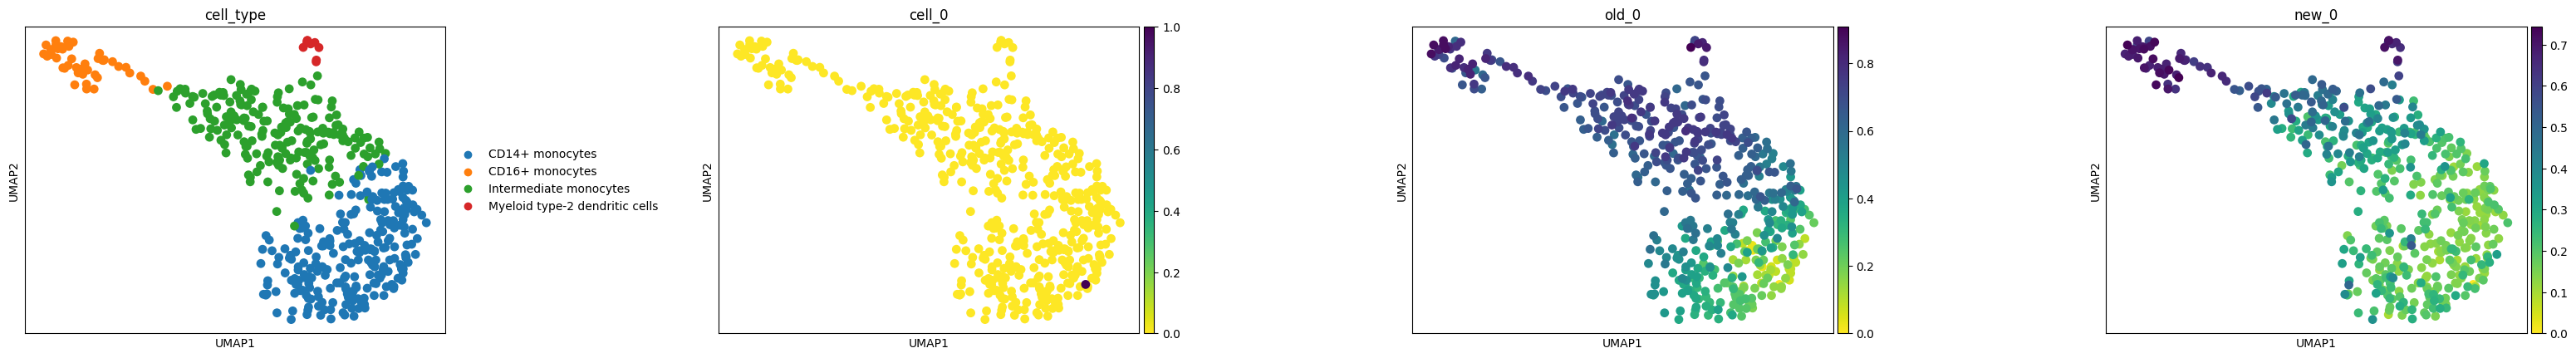

In [130]:
sc.pl.umap(subset, color=['cell_type', "cell_0", 'old_0', 'new_0'], wspace = .5, cmap='viridis_r')


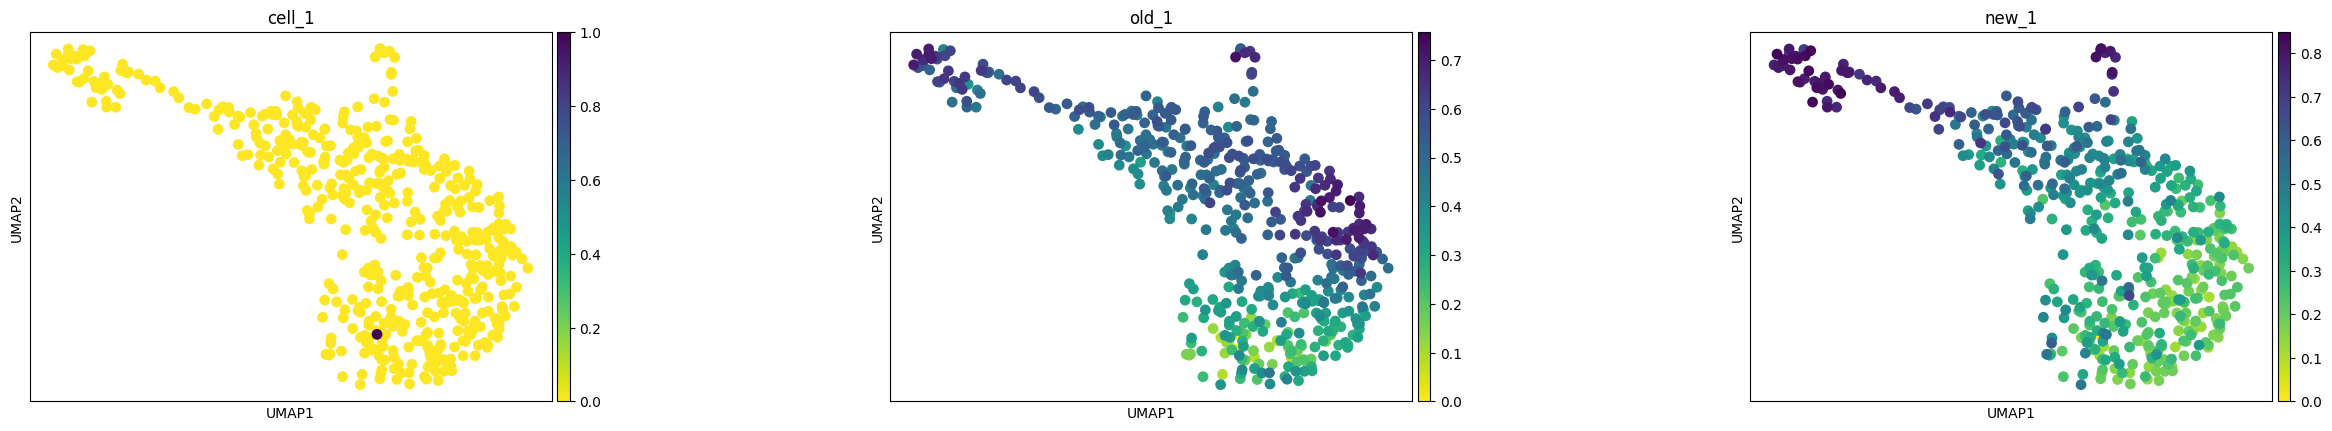

In [110]:
sc.pl.umap(subset, color=["cell_1", 'old_1', 'new_1'], wspace = .5, cmap='viridis_r')


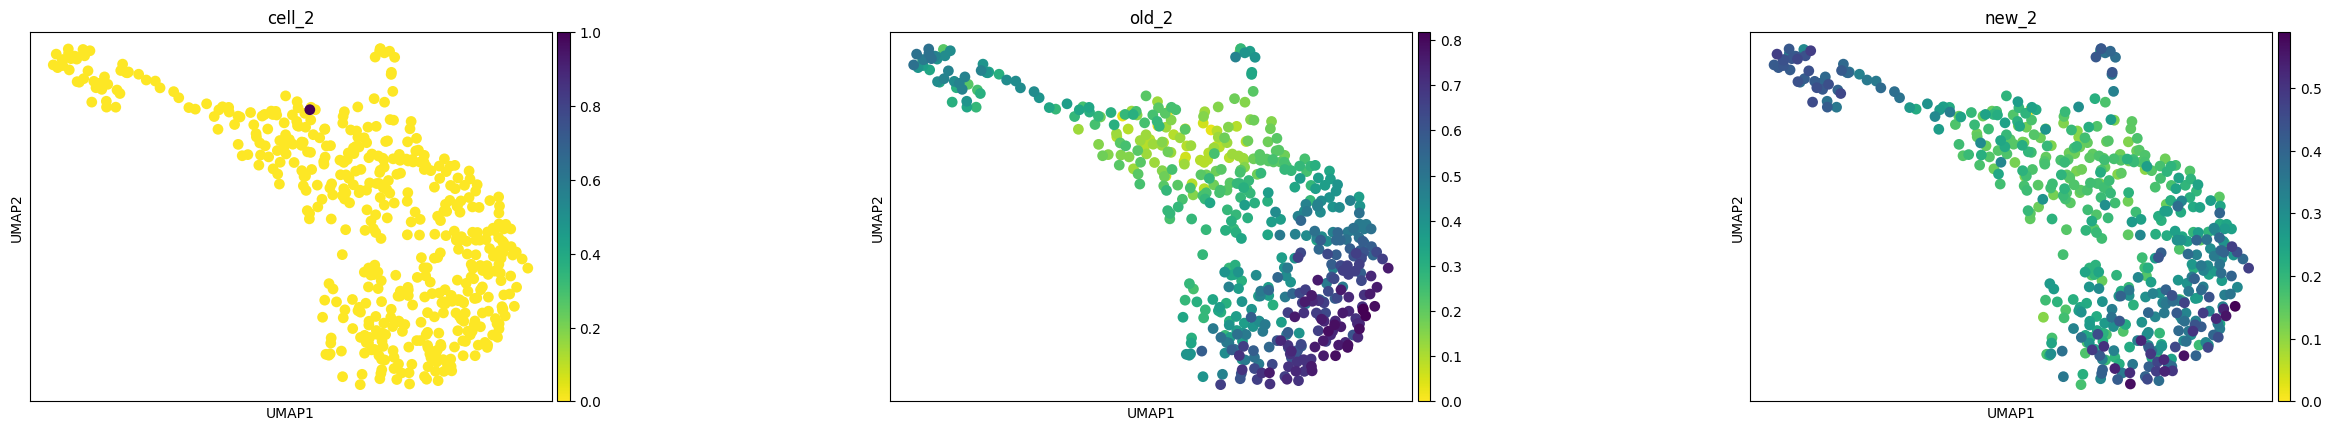

In [111]:
sc.pl.umap(subset, color=["cell_2", 'old_2', 'new_2'], wspace = .5, cmap='viridis_r')


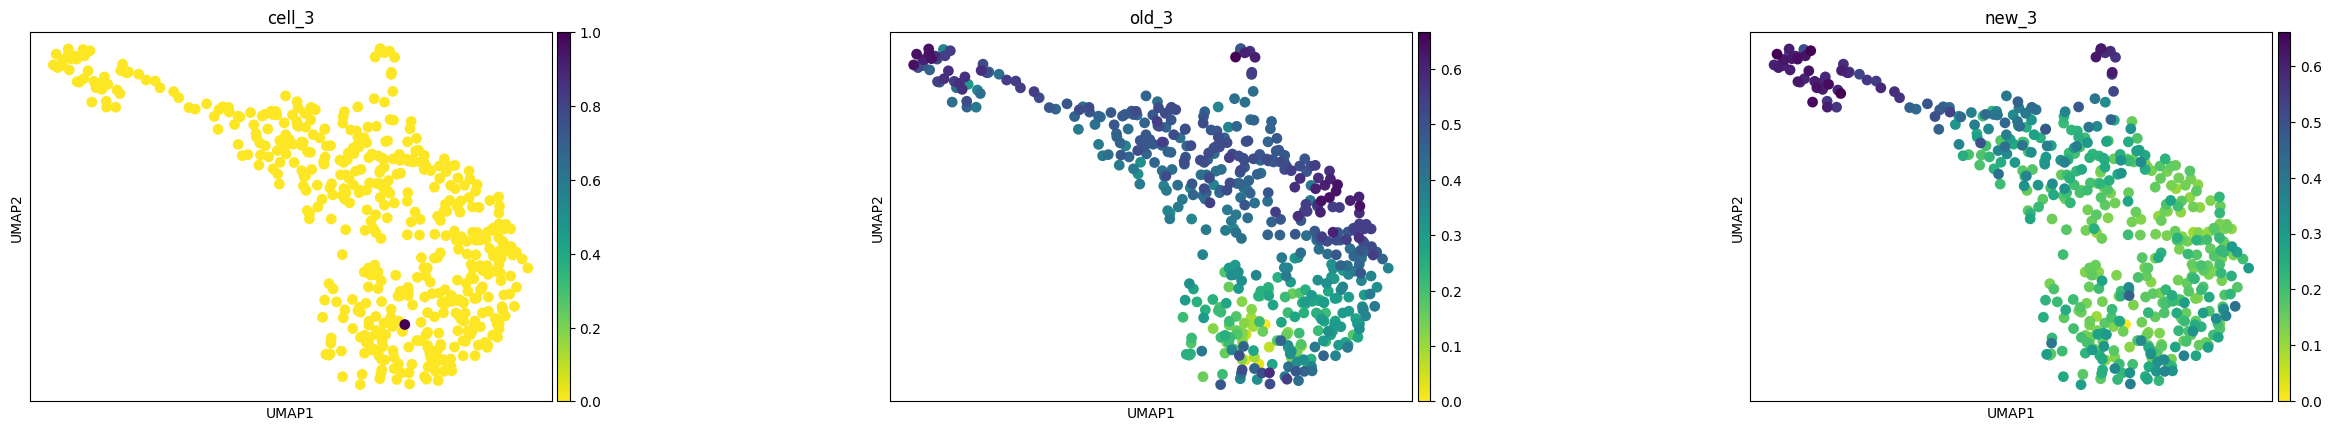

In [112]:
sc.pl.umap(subset, color=["cell_3", 'old_3', 'new_3'], wspace = .5, cmap='viridis_r')


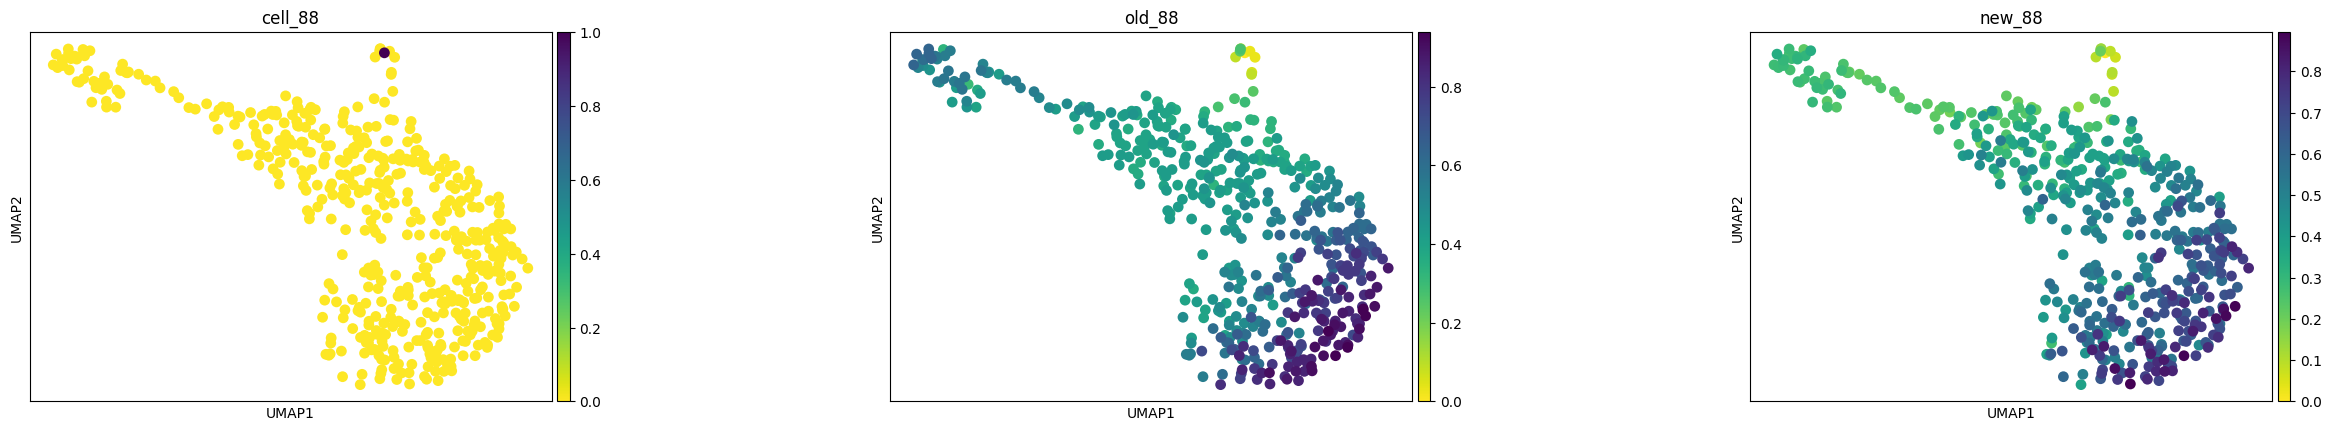

In [134]:
sc.pl.umap(subset, color=["cell_88", 'old_88', 'new_88'], wspace = .5, cmap='viridis_r')


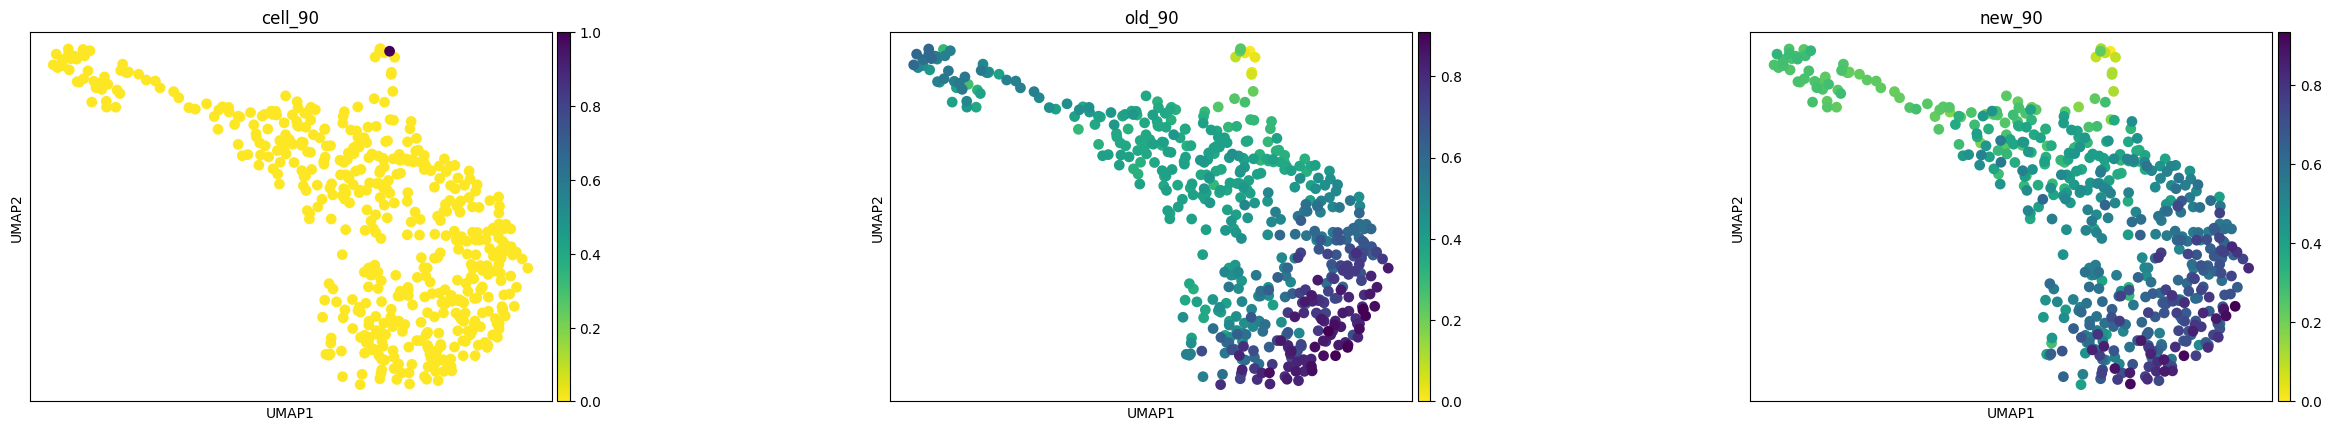

In [135]:
sc.pl.umap(subset, color=["cell_90", 'old_90', 'new_90'], wspace = .5, cmap='viridis_r')


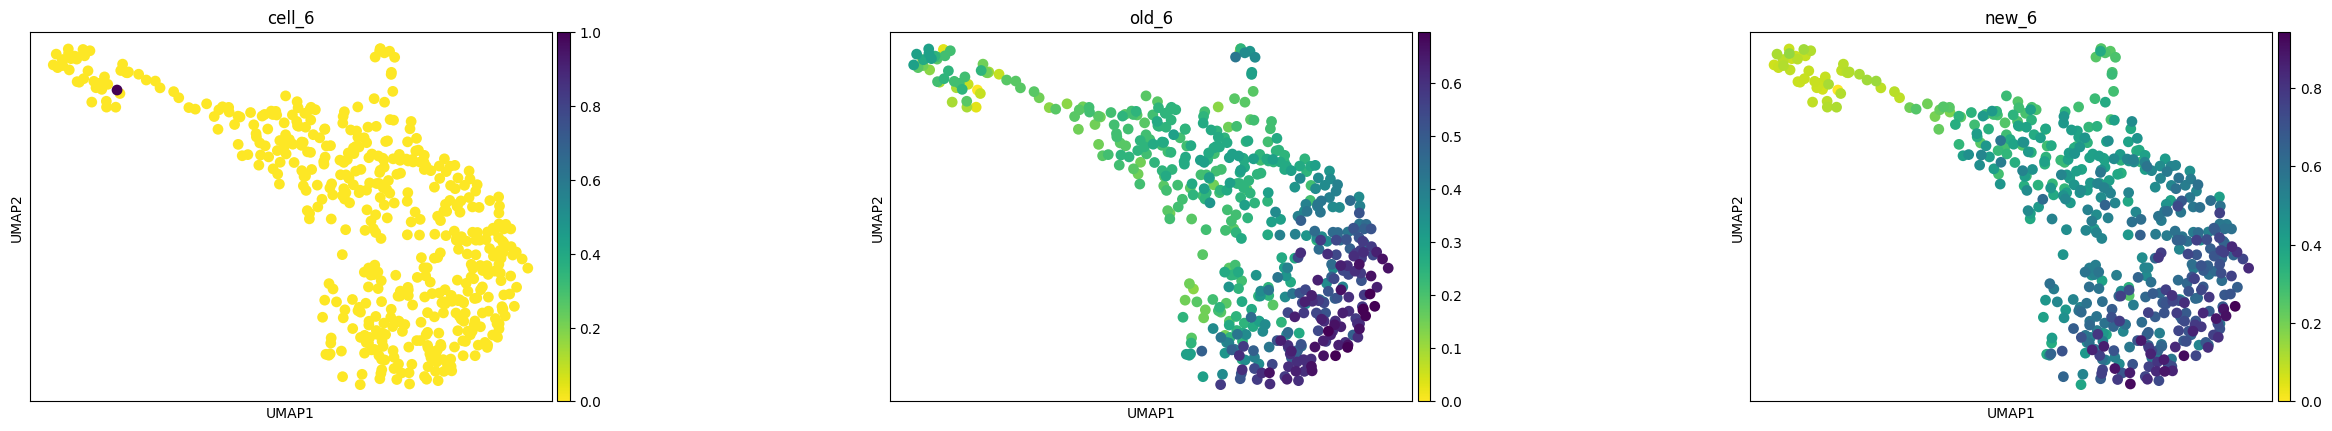

In [119]:
sc.pl.umap(subset, color=["cell_6", 'old_6', 'new_6'], wspace = .5, cmap='viridis_r')


### Iterate: get gene trajectory again on top of revised cell graph/cell trajectories

In [31]:
gene_dist_mat = cal_ot_mat(gene_expr=gene_expression_updated, 
                           ot_cost=old_cell_dist_mat, 
                           show_progress_bar=True)

100%|██████████| 31375/31375 [00:03<00:00, 10340.23it/s] 


In [32]:
gene_dist_mat2 = cal_ot_mat(gene_expr=gene_expression_updated, 
                           ot_cost=new_cell_dist_mat, 
                           show_progress_bar=True)

100%|██████████| 31375/31375 [00:05<00:00, 5400.73it/s]  


<Axes: >

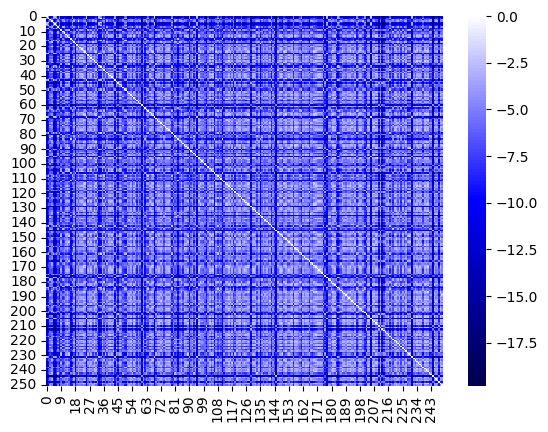

In [33]:
sns.heatmap(gene_dist_mat2 - gene_dist_mat, center=0, cmap='seismic')

<Axes: >

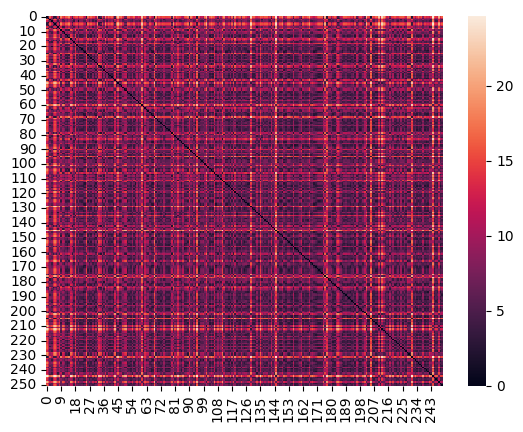

In [ ]:
sns.heatmap(gene_dist_mat)

<Axes: >

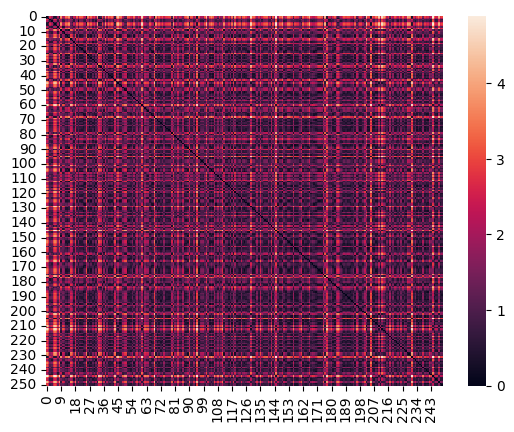

In [ ]:
sns.heatmap(gene_dist_mat2)

In [47]:
# use diffusion map to get gene embedding
gene_embedding2, _ = get_gene_embedding(gene_dist_mat2, k = 5)
gene_trajectory2 = extract_gene_trajectory(gene_embedding2, gene_dist_mat2, t_list = [4, 10, 10], gene_names=genes, k=3)


In [48]:
temp = gene_trajectory2['DM_3']
gene_trajectory2['DM_3'] = gene_trajectory2['DM_1']
gene_trajectory2['DM_1'] = temp

In [145]:
temp = gene_trajectory2['DM_3']
gene_trajectory2['DM_3'] = -temp

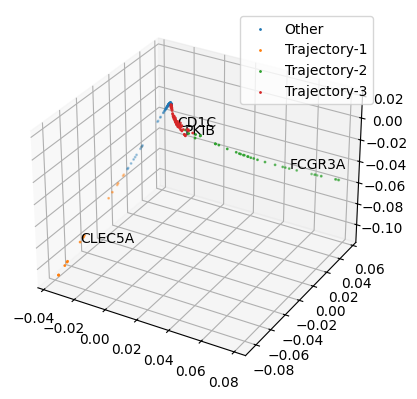

In [146]:

plot_gene_trajectory_3d(gene_trajectory2, label_genes=['CLEC5A', 'CD1C', 'FCGR3A', 'PKIB'])

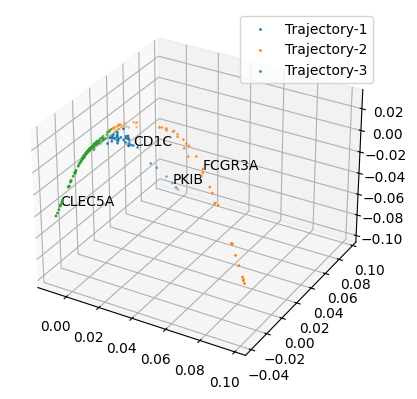

In [ ]:
plot_gene_trajectory_3d(gene_trajectory, label_genes=['CLEC5A', 'CD1C', 'FCGR3A', 'PKIB'])

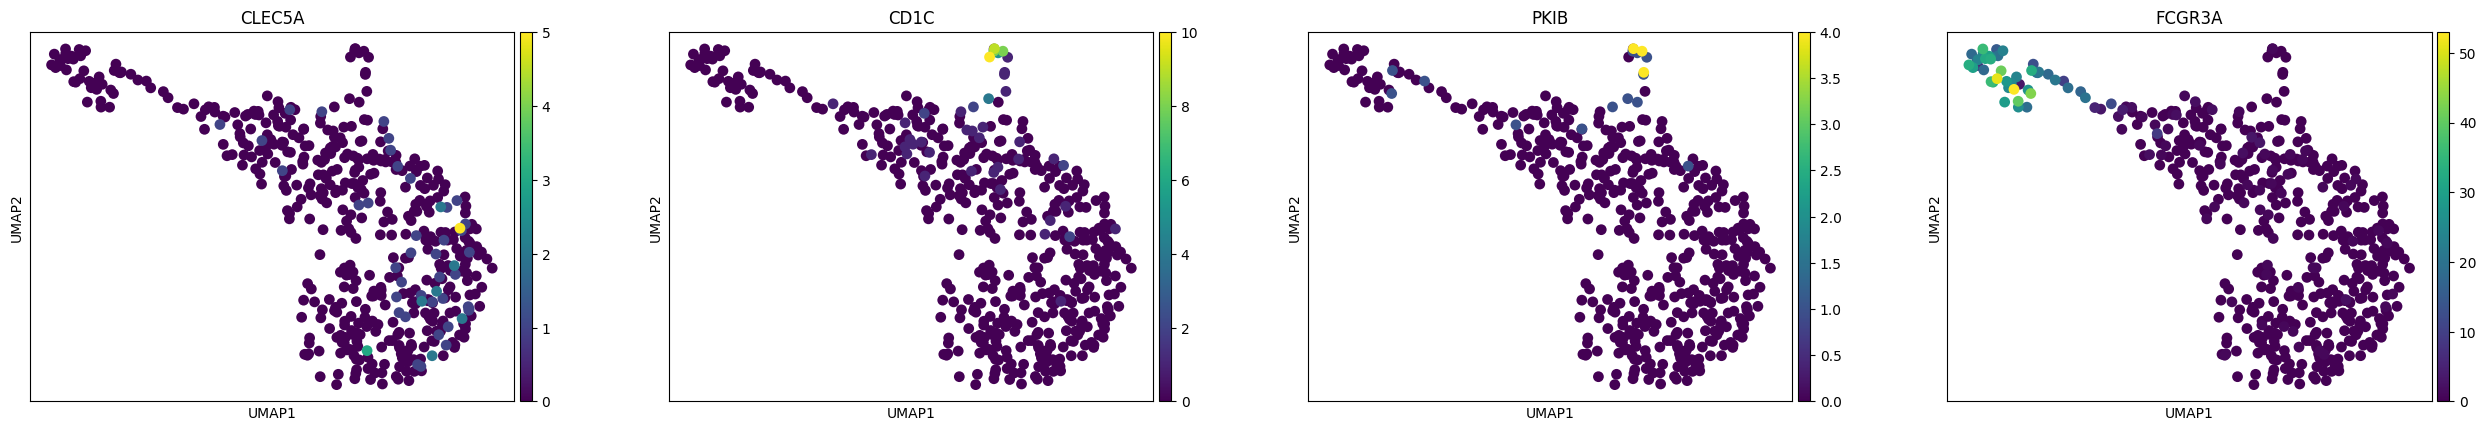

In [111]:
sc.pl.umap(subset, color=['CLEC5A', 'CD1C',  'PKIB', 'FCGR3A'], wspace = .2)
